# Digit Recognizer

### Competition Description
MNIST (*Modified National Institute of Standards and Technology*) is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We will experiment with different algorithms to learn first-hand what works well and how techniques compare.

### Plan:
1. Data Ingestion and Split
2. EDA
3. Data Cleaning
   * Dimensionality Reduction
   * Normalization
4. Data Pipelines
5. Building and Training a Simple Classifier
6. Evaluation
   * Metrics (accuracy, precision, recall, f-score)
   * Cross Validation (Bias-Variance tradeoff)
   * Confusion Matrix (use heatmap for error analysis)
7. Custom Function - code reuse
8. Train Distinct ML Models
   * Linear Classifier
   * SVM Classifier
   * Logistic Regression
   * Random Forest
   * XGBoost Classifier
9. CNN
10. Choosing The Best Model and Submit Predictions

## 1. Data Ingestion and Split

In [1]:
# Lets import all the necessary libraries for this task first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Lets check the dimensions of our dataset next
data.shape

(42000, 785)

Next, lets split the data into train, val, and test sets. We will use stratified split incase our train, val, and test sets are not good representatives of the population.

In [5]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,1:]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [6]:
# Lets examine if our distinct sets are goods samples
perc = list()
for y in [y_train, y_val, y_test]:
    perc.append(y.value_counts(normalize=True).sort_index())
pd.DataFrame(np.array(perc).T, columns=['y_train', 'y_val', 'y_test'])

,y_train,y_val,y_test
0,0.099728,0.096032,0.093386
1,0.112075,0.110091,0.110582
2,0.098061,0.103741,0.100265
3,0.101905,0.107029,0.108730
4,0.096939,0.099887,0.090212
5,0.092177,0.085374,0.087831
6,0.097993,0.099320,0.100529
7,0.103469,0.107483,0.108730
8,0.097075,0.093537,0.101587
9,0.100578,0.097506,0.098148


Indeed, all of the sets are good representatives of the population. Therefore, we can move on to next task. Otherwise, we could have use StratifiedShuffleSplit from sklearn's model_selection module.

So good practice is to hold the test data to the very end of our work and never explore it. Lets quickly look at the size of these sets next.

In [7]:
print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Training set: {X_test.shape[0]}")

Training set: 29400
Validation set: 8820
Training set: 3780


## 2.EDA

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29400 entries, 15673 to 15795
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 176.1 MB


In [9]:
print(f"# of Rows: {X_train.shape[0]}")
print(f"# of Columns: {X_train.shape[1]}")

# of Rows: 29400
# of Columns: 784


In [10]:
X_train.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,...,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.0,29400.0,29400.0,29400.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.213980,0.115272,0.069728,0.028469,0.019388,0.004082,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.354561,4.467579,3.651858,2.102425,2.078635,0.495138,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


It seems like most the valuable information is located in only a subset of feature space. Therefore, it might be worth running some dimensionaly reduction techniques like PCA. Lets confirm this trend by visualizing a small sample of the data next.

In [11]:
sample_index = np.random.choice(range(29400), 10).tolist()
sample = X_train.iloc[sample_index,:]

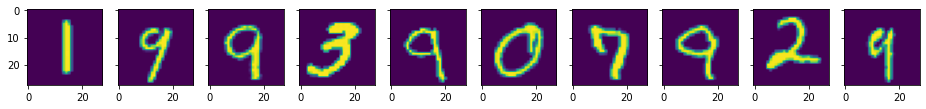

In [12]:
sample_clean = np.array(sample).reshape(10,28,28)
fig, axs = plt.subplots(ncols=10, sharey=True,figsize=(16,16))
for i,img in enumerate(sample_clean):
    axs[i].imshow(img)

Cool, our predictions is true. Hence, it will be worthwhile to implement PCA in practice in the data cleaning step. 

## 3.Data Cleaning

In [13]:
# # First of all, lets scale the features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

In [14]:
# # Dimensionality Reduction
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)
# pca.fit(X_train)

In [15]:
# X_train = pca.transform(X_train)
# X_train.shape

## 4.Data Pipelines

Alternatively, we can build pipelines for data cleaning or transformatoin tasks. Indeed, it is the recommended way and we will stick to it next.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95))
])

In [17]:
X_train = pipeline.fit_transform(X_train)

We can play with the hyparameter n_components later on to find its best value for this problem.

## 5.Building and Training a Simple Classifier

Lets start with perhaps the simplest of all, the perceptron model. For now we will stick with just one model. Perform model evaluation and hyperparameter tuning. Then, once we build a custom function to train and evaluate distinct models simultaneously, we will come back and give a shot to other ml models too without having to type all the lines of code again and over.

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
# As this is a multiclass problem, we will use sklearn OvR techinique as generalization of binary classification
from sklearn.multiclass import OneVsRestClassifier

In [20]:
lin_clf = OneVsRestClassifier(SGDClassifier(loss='perceptron', max_iter=2000))

In [21]:
lin_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(loss='perceptron', max_iter=2000))

## 6. Evaluation

Next, lets evaluate this simple model.

In [22]:
train_predictions = lin_clf.predict(X_train)

In [23]:
X_val_prepared = pipeline.transform(X_val)
val_predictions = lin_clf.predict(X_val_prepared)

### Accuracy

In [24]:
from sklearn.metrics import accuracy_score
print(f"Training Accuracy:{accuracy_score(y_train, train_predictions)}")
print(f"Validation Accuracy:{accuracy_score(y_val, val_predictions)}")

Training Accuracy:0.9166666666666666
Validation Accuracy:0.9023809523809524


It seems like our model overfits a bit. We will confirm it soon using a technique called cross-validation.

### Other Classification Metrics

The other key classification metrics are precision_score, recall_score, and f1_score which work well in the binary case. For simpilicity, we will stick with accuracy for now.

### Cross Validation

In [25]:
# We can also use cross-validation to get a sense how well our model generalizes
from sklearn.model_selection import cross_val_score
cvs = cross_val_score(lin_clf, X_train, y_train, scoring="accuracy", cv=10)

In [26]:
cvs.mean()

0.9065646258503401

### Confusion Matrix

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, val_predictions)

array([[804,   0,   3,   1,   2,   9,   8,   0,  20,   0],
       [  0, 929,   7,   1,   1,   6,   0,   2,  24,   1],
       [  3,   3, 808,  16,  11,   6,  10,   8,  50,   0],
       [  2,   5,  14, 794,   1,  35,   2,   6,  68,  17],
       [  2,   1,   8,   3, 785,   3,   6,   1,  43,  29],
       [  6,   4,   1,  18,  12, 632,  14,   3,  53,  10],
       [  7,   4,   6,   0,   3,  10, 830,   0,  16,   0],
       [  1,   2,  12,  10,  10,   1,   1, 849,  17,  45],
       [  1,   4,   5,  13,   2,  24,   3,   2, 765,   6],
       [  2,   6,   4,  10,  17,   4,   0,  18,  36, 763]])

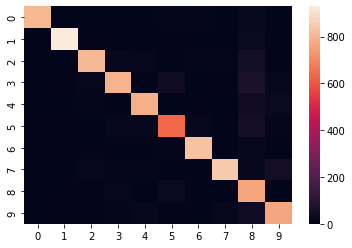

In [28]:
# Let's visualize this matrix using heatmap
import seaborn as sns
sns.heatmap(confusion_matrix(y_val, val_predictions))
plt.show()

Hmm. Not very informative. Lets try to fill the diagonal entries with 0s, normalize rest of the entries, and then analyse the error.

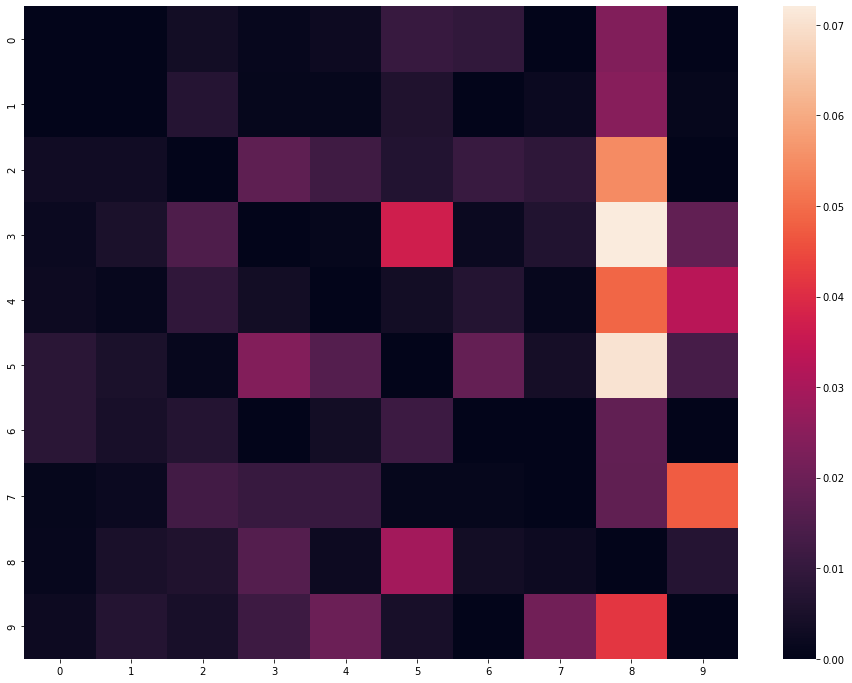

In [29]:
cm = confusion_matrix(y_val, val_predictions)
norm_cm = cm/cm.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_cm, 0)

plt.figure(figsize=(16,12))
sns.heatmap(norm_cm)
plt.show()

Here we can see that 3 and 5 were often confused. Also, many images have been misclassified as 9.

## 7.Custom Function

In [30]:
def classify_digits(classifier, train_x, train_y, test_x, test_y, iterations, params):
    # Data Preparation
    train_x = pipeline.fit_transform(train_x)
    test_x = pipeline.transform(test_x)
    
    # Grid Search Cross Validation
    from sklearn.model_selection import GridSearchCV
    gs_cv = GridSearchCV(classifier, param_grid=params, scoring="accuracy", cv=3, refit=True)
    gs_cv.fit(train_x, train_y)
    
    # Best Parameters
    print(f"Best Parameters: {gs_cv.best_params_}")
    # Training Model
    gs_cv.fit(train_x, train_y)
    
    # Model Predictions
    train_predictions = gs_cv.predict(train_x)
    test_predictions = gs_cv.predict(test_x)
    
    # Model Evaluation
    print("Accuracy Scores:")
    print(f"Training Accuracy:{accuracy_score(train_y, train_predictions)}")
    print(f"Validation Accuracy:{accuracy_score(test_y, test_predictions)}")
    print("")
    
    # Cross Validation
    cv = cross_val_score(gs_cv, train_x, train_y, scoring="accuracy", cv=3)
    print(f"Cross Validation Accuracy: {cv.mean()}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_y, test_predictions)
    norm_cm = cm/cm.sum(axis=1, keepdims=True)
    np.fill_diagonal(norm_cm, 0)

    plt.figure(figsize=(10,8))
    sns.heatmap(norm_cm)
    plt.show()

## 8. Train Distinct ML Models

The following script is just to hide jupyter warnings. No need to go into details.

In [2]:
import warnings
warnings.filterwarnings('ignore')

As we are going to run everything from scratch, lets make sure we have the data in the raw format next.

In [32]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,1:]
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

## *Perceptron Model*

In [33]:
# Define Model
from sklearn.linear_model import SGDClassifier
lm = SGDClassifier(loss='perceptron')

from sklearn.multiclass import OneVsRestClassifier
lin_clf = OneVsRestClassifier(lm)

Best Parameters: {'estimator__alpha': 0.001}
Accuracy Scores:
Training Accuracy:0.9124829931972789
Validation Accuracy:0.9036281179138322

Cross Validation Accuracy: 0.9066666666666666


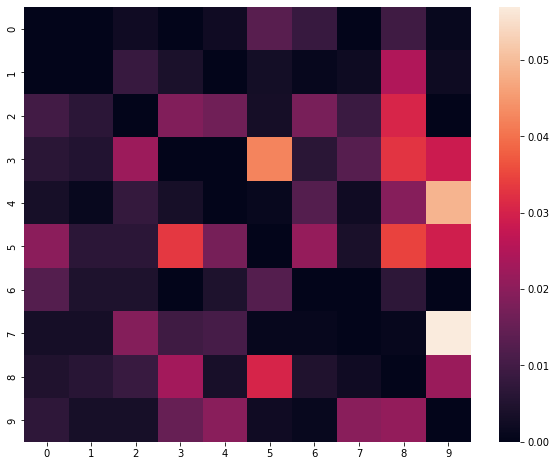

In [34]:
# Train and evaluate model
classify_digits(lin_clf, X_train, y_train, X_val, y_val, 2000, {"estimator__alpha":[0.01,0.001]})

Sweet. we are ready to accomplish all the work we have done so far with just a few lines of code. Lets continue the momentum and look at the performance of more advanced ml models such as svm, logistic regression, decision tree (ensemle), and XGBoost next.

## *SVM*

In [35]:
# define model
from sklearn.svm import SVC
svc = SVC(C=0.1)

# Alternatively, we can define it in a more efficient way as follows
# svc = SGDClassifier(loss="hinge")

from sklearn.multiclass import OneVsRestClassifier
svm_clf = OneVsRestClassifier(svc)

Best Parameters: {'estimator__C': 10}
Accuracy Scores:
Training Accuracy:0.9984353741496599
Validation Accuracy:0.9723356009070295

Cross Validation Accuracy: 0.9669727891156463


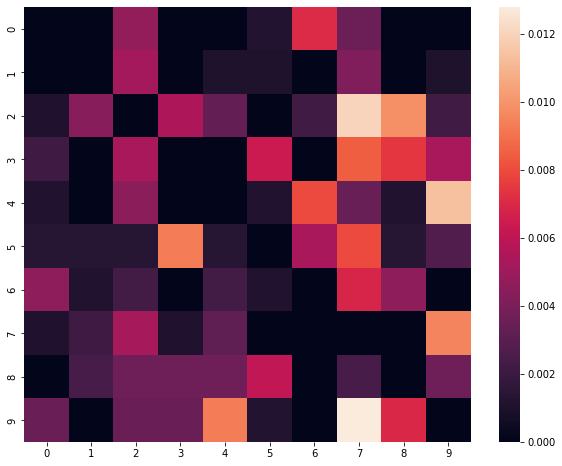

In [36]:
# Train and evaluate model
classify_digits(svm_clf, X_train, y_train, X_val, y_val, 2000, {"estimator__C":[0.1,1,10]})

## *Logistic Regression*

In [37]:
# define model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

# Alternatively, we can define it in a more efficient way as follows
# log_reg = SGDClassifier(loss="log_loss")

Best Parameters: {'C': 0.01}
Accuracy Scores:
Training Accuracy:0.934795918367347
Validation Accuracy:0.9218820861678004

Cross Validation Accuracy: 0.9193197278911566


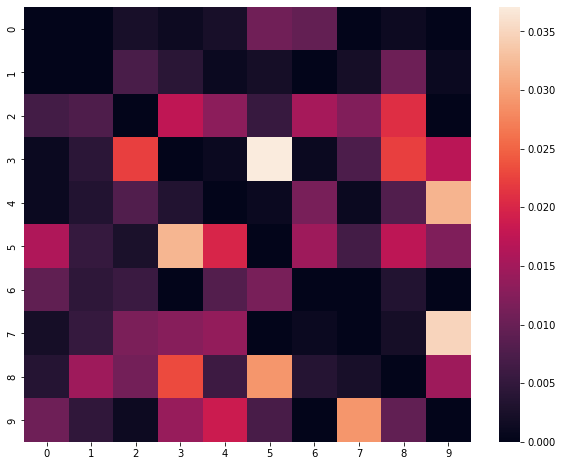

In [38]:
# Train and evaluate model
classify_digits(log_reg, X_train, y_train, X_val, y_val, 2000, {"C":[0.01,0.1,1,10]})

## *Random Forest*

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=150)

Best Parameters: {'max_depth': 10}
Accuracy Scores:
Training Accuracy:0.9623809523809523
Validation Accuracy:0.9090702947845805

Cross Validation Accuracy: 0.906734693877551


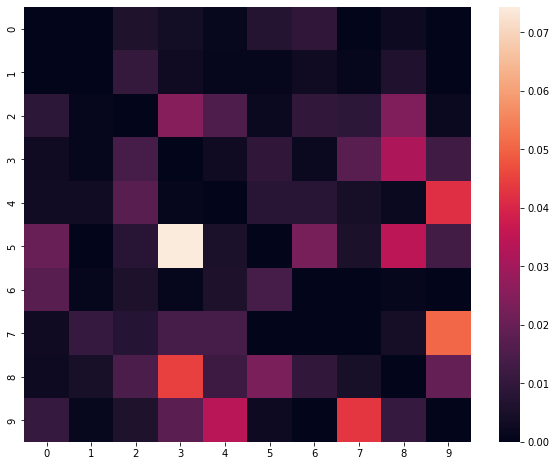

In [40]:
# Train and evaluate model
classify_digits(rf_clf, X_train, y_train, X_val, y_val, 2000, {"max_depth":[5,10]})

## *XGBoost*

In [41]:
from xgboost import XGBClassifier

In [42]:
xgb_clf = XGBClassifier(n_estimators=50, max_depth=10, eval_metric='mlogloss')

Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy Scores:
Training Accuracy:1.0
Validation Accuracy:0.9498866213151927

Cross Validation Accuracy: 0.9393537414965986


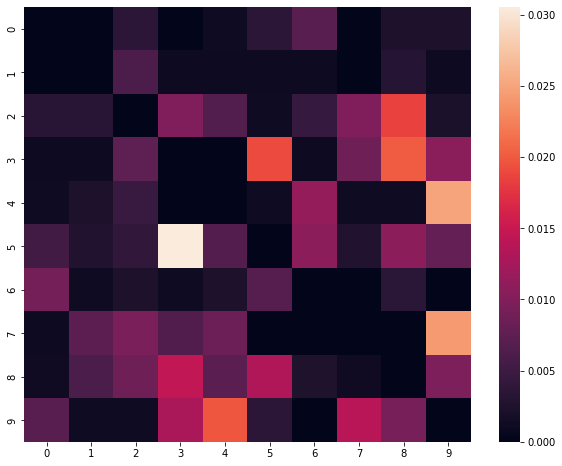

In [43]:
# Train and evaluate model
classify_digits(xgb_clf, X_train, y_train, X_val, y_val, 2000, {"n_estimators":[50,100], "max_depth":[10,20]})

## 9. CNN

In [3]:
from tensorflow import keras

In [4]:
# data ingestion
data = pd.read_csv("train.csv")

# split into training features and labels
X = data.iloc[:,1:]
y = data['label']

# Lets change the dimensions of our dataset from 2D to 3D
X = np.array(X).reshape(X.shape[0],28,28)

# split the entire dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [5]:
# Lets build the model first
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same", input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=784, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
     
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.1),
    
    keras.layers.Dense(10, activation="softmax"),
])

In [6]:
# Next, lets look at the model's structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 64)       0         
 )                                                               
                                                                 
 normalization (Normalizatio  (None, 10, 10, 64)       129       
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 128)        0

In [7]:
# Now, compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [8]:
my_callbacks = [keras.callbacks.EarlyStopping(patience=3)]

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=my_callbacks)

Epoch 1/100
919/919 [==============================] - 23s 24ms/step - loss: 0.7220 - accuracy: 0.7651 - val_loss: 0.1472 - val_accuracy: 0.9562
Epoch 2/100
919/919 [==============================] - 22s 24ms/step - loss: 0.1756 - accuracy: 0.9431 - val_loss: 0.1052 - val_accuracy: 0.9663
Epoch 3/100
919/919 [==============================] - 22s 24ms/step - loss: 0.1174 - accuracy: 0.9626 - val_loss: 0.0811 - val_accuracy: 0.9748
Epoch 4/100
919/919 [==============================] - 22s 23ms/step - loss: 0.0917 - accuracy: 0.9706 - val_loss: 0.0591 - val_accuracy: 0.9827
Epoch 5/100
919/919 [==============================] - 22s 24ms/step - loss: 0.0789 - accuracy: 0.9746 - val_loss: 0.0460 - val_accuracy: 0.9871
Epoch 6/100
919/919 [==============================] - 22s 24ms/step - loss: 0.0686 - accuracy: 0.9786 - val_loss: 0.0505 - val_accuracy: 0.9850
Epoch 7/100
919/919 [==============================] - 22s 24ms/step - loss: 0.0561 - accuracy: 0.9823 - val_loss: 0.0372 - val_ac

In [9]:
model.evaluate(X_test, y_test)

119/119 [==============================] - 1s 10ms/step - loss: 0.0372 - accuracy: 0.9878


[0.03721209242939949, 0.9878306984901428]

In [10]:
val_predictions = np.argmax(model.predict(X_val), axis=1)
val_predictions

array([0, 2, 6, ..., 4, 2, 6])

### Error Analysis

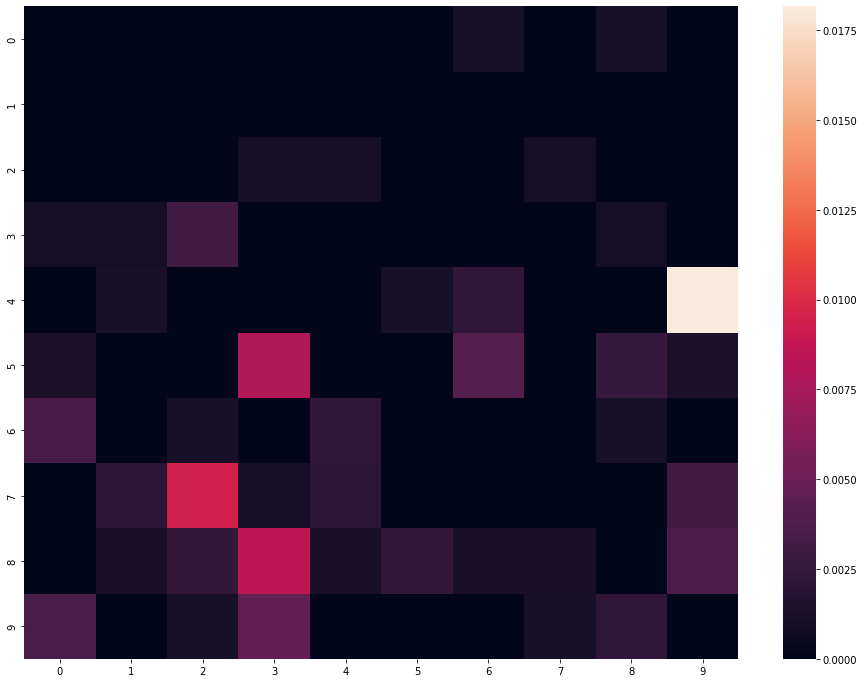

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, val_predictions)
norm_cm = cm/cm.sum(axis=1, keepdims=True)
np.fill_diagonal(norm_cm, 0)

plt.figure(figsize=(16,12))
sns.heatmap(norm_cm)
plt.show()

It seems like our model is often confused between 4 and 9. 

## 10. Choosing The Best Model and Submit Predictions

It is evident that CNN is the best model for this classification problem with an accuracy close to 99%.

In [12]:
# Lets train this CNN model on the entire training set

# data ingestion
data = pd.read_csv("train.csv")

# split into training features and labels
X = data.iloc[:,1:]
y = data['label']

# Lets change the dimensions of our dataset from 2D to 3D
X = np.array(X).reshape(X.shape[0],28,28)

# Lets build the model first
final_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same", input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=784, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3), padding="same"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.2),
     
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Normalization(),
    keras.layers.Dropout(0.1),
    
    keras.layers.Dense(10, activation="softmax"),
])

# Now, compile the model
final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

# Next, lets train the model
my_callbacks = [keras.callbacks.EarlyStopping(patience=3)]
final_model.fit(X, y, validation_split=0.2, epochs=100, verbose=1, callbacks=my_callbacks)

Epoch 1/100
1050/1050 [==============================] - 24s 23ms/step - loss: 0.6600 - accuracy: 0.7834 - val_loss: 0.1725 - val_accuracy: 0.9482
Epoch 2/100
1050/1050 [==============================] - 24s 23ms/step - loss: 0.1633 - accuracy: 0.9488 - val_loss: 0.1005 - val_accuracy: 0.9681
Epoch 3/100
1050/1050 [==============================] - 23s 22ms/step - loss: 0.1114 - accuracy: 0.9652 - val_loss: 0.0598 - val_accuracy: 0.9820
Epoch 4/100
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0842 - accuracy: 0.9733 - val_loss: 0.0525 - val_accuracy: 0.9835
Epoch 5/100
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0709 - accuracy: 0.9771 - val_loss: 0.0418 - val_accuracy: 0.9876
Epoch 6/100
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0636 - accuracy: 0.9797 - val_loss: 0.0412 - val_accuracy: 0.9874
Epoch 7/100
1050/1050 [==============================] - 23s 22ms/step - loss: 0.0549 - accuracy: 0.9819 - val_loss: 0

### *Make and Submit Predictions*

First read in and prepare the test data.

In [13]:
# data ingestion
X_test = pd.read_csv("test.csv")

# Lets change the dimensions of our dataset from 2D to 3D
X_test = np.array(X_test).reshape(X_test.shape[0],28,28)

In [14]:
# Make predictions
final_predictions = np.argmax(final_model.predict(X_test),axis=1)

In [15]:
image_id = np.arange(1,X_test.shape[0]+1)

In [16]:
# Submit predictions
my_submission = pd.DataFrame({'ImageId': image_id, 'Label': final_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('my_submission.csv', index=False)

## Next Steps

1. **Fine Tuning:**
    We can fine tune popular models like VGG16 for this task as a form of transfer learning.
2. **Data Augmentation:**
    We can generate more data for the labels 4's and 9's as these 2 labels were often confused to see if this startegy improves the performance of our model.
3. **Use "rbf" kernel:**
    The second in line was the svm classifier. If you have more time and computational resources, you can give a shot to tuning svm hyperparameters and use powerful kernels like rbf.
    